In [9]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr
from sklearn.linear_model import LogisticRegression
from scipy.stats import pointbiserialr, pearsonr, spearmanr, kendalltau
from natsort import natsort_keygen
from itertools import combinations

## Plotting parameters

In [10]:
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

FIGWIDTH = 7.00697
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
N_TRIALS = 20

# green for gpt-4v, gray for fuyu, purple for adapter, teal for otter, red for humans
model_colors = [
    "#50b990",
    "#8c92ac",
    "#624fe8",
    "#008080",
    "#9b443e",
]

cmap = [
    "#53665c",
    "#ccb3a0",
    "#f4b368",
    "#a08158",
    "#c87858",
    "#94b1d2",
    "#c5d9d8",
    "#e6b951",
    "#666666",
]
sns.set_palette(cmap)


plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


latex_context = {
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
}


# retina figures
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["savefig.dpi"] = 300

## Load data

In [11]:
# Load data from our own collected .csv file
data_jenga = pd.read_csv("data/JENGA_RESULTS.csv").loc[:, :"OTTER"]

# Define subjects
subjects = ["HumanAvg", "GPT4V", "FUYU", "ADAPTER", "OTTER"]

# Human data from Gerstenberg
human_responsibility = pyreadr.read_r('data/exp1_responsibility.RData')['df.exp1.responsibility']
human_prediction = pyreadr.read_r('data/exp1_prediction.RData')['df.exp1.prediction']

# Print first five rows
data_jenga.head()

,Image,Experiment,Condition,GT,HumanAvg,GPT4V,FUYU,ADAPTER,OTTER
0,1,1,counting,7.0,NaN,7,4.0,10,12
1,2,1,counting,7.0,NaN,10,4.0,10,12
2,3,1,counting,8.0,NaN,10,4.0,10,12
3,4,1,counting,9.0,NaN,10,4.0,5,12
4,5,1,counting,12.0,NaN,13,8.0,10,12


#### Add human responsibility and prediction judgements

In [12]:
participants = np.sort(np.concatenate((np.unique(human_responsibility["participant"].values), np.unique(human_prediction["participant"].values))))
participant_responsibility = np.zeros(len(participants))
participant_predictions = np.zeros(len(participants))

# Add participant to main data frame
for participant in participants:
    data_jenga[f"H{participant}"] = np.zeros(data_jenga.shape[0])
    data_jenga[f"H{participant}"] = np.nan

#### Add human responsibility judgements

In [13]:
# Loop through human participants
for ind, participant in enumerate(participants):

    # For responsibility answer
    part_df =  human_responsibility[human_responsibility["participant"] == participant]

    # Loop through trials
    for row in range(part_df.shape[0]):
        
        # Add into dataframe
        data_jenga.loc[(data_jenga["Experiment"] == 3) & (data_jenga["Image"] == part_df.iloc[row].trial), f"H{participant}"] = part_df.iloc[row].response

#### Add human prediction judgements

In [14]:
# Loop through human participants
for ind, participant in enumerate(participants):

    # For prediction answer
    part_df =  human_prediction[human_prediction["participant"] == participant]

    # Loop through trials
    for row in range(part_df.shape[0]):
        
        # Add into dataframe
        data_jenga.loc[(data_jenga["Experiment"] == 2) & (data_jenga["Image"] == part_df.iloc[row].trial), f"H{participant}"] = part_df.iloc[row].response

## Analyze match to ground truth

In [22]:
# Loop through experiments 1 and 2 and calculate absolute distance to ground truth for each subject
mean_absolute_dists = np.zeros((3, 2, len(subjects[1:])))
for ind_exp, exp in enumerate([1, 2, 3]):

    # Loop through all subjects
    for ind_sub, subject in enumerate(subjects[1:]):  

        # Absolute distance to ground truth and absolute distance to human average
        mean_absolute_dists[ind_exp, 0, ind_sub] = np.nanmean(abs(data_jenga[data_jenga["Experiment"] == exp][subject].values - data_jenga[data_jenga["Experiment"] == exp]["GT"].values))
        mean_absolute_dists[ind_exp, 1, ind_sub] = np.nanmean(abs(data_jenga[data_jenga["Experiment"] == exp][subject].values - data_jenga[data_jenga["Experiment"] == exp]["HumanAvg"].values))
        print(f"Experiment {exp}: mean absolute distance between {subject} answers and ground truth is {mean_absolute_dists[ind_exp, 0, ind_sub]:.2f}.")
        print(f"Experiment {exp}: mean absolute distance between {subject} answers and human average is {mean_absolute_dists[ind_exp, 1, ind_sub]:.2f}.")

# Get absolute distance for each human to ground truth in experiment 2
human_subjects = data_jenga.columns[9:]
mean_absolute_dists_humans_exp2 = np.zeros((len(human_subjects)))
for ind_hum, human in enumerate(human_subjects):
    mean_absolute_dists_humans_exp2[ind_hum] = np.nanmean(abs(data_jenga[data_jenga["Experiment"] == 2][human].values - data_jenga[data_jenga["Experiment"] == 2]["GT"].values))

# Get absolute distance for each human to ground truth in experiment 3
mean_absolute_dists_humans_exp3 = np.zeros((len(human_subjects)))
for ind_hum, human in enumerate(human_subjects):
    mean_absolute_dists_humans_exp3[ind_hum] = np.nanmean(abs(data_jenga[data_jenga["Experiment"] == 3][human].values - data_jenga[data_jenga["Experiment"] == 3]["HumanAvg"].values))

# Calculate difference from average of uniform distribution for random agent 
random_dists = np.zeros(2)
exp1mean = np.mean((data_jenga[data_jenga["Experiment"] == 1]["GT"].min(), data_jenga[data_jenga["Experiment"] == 1]["GT"].max()))
exp2means = np.mean(np.vstack((np.zeros(len(data_jenga[data_jenga["Experiment"] == 1]["GT"])), data_jenga[data_jenga["Experiment"] == 1]["GT"])), axis=0)
random_dists[0] = np.nanmean(abs(exp1mean - data_jenga[data_jenga["Experiment"] == 1]["GT"].values))
random_dists[1] = np.nanmean(abs(exp2means - data_jenga[data_jenga["Experiment"] == 2]["GT"].values))

Experiment 1: mean absolute distance between GPT4V answers and ground truth is 2.02.
Experiment 1: mean absolute distance between GPT4V answers and human average is nan.
Experiment 1: mean absolute distance between FUYU answers and ground truth is 4.26.
Experiment 1: mean absolute distance between FUYU answers and human average is nan.
Experiment 1: mean absolute distance between ADAPTER answers and ground truth is 3.81.
Experiment 1: mean absolute distance between ADAPTER answers and human average is nan.
Experiment 1: mean absolute distance between OTTER answers and ground truth is 2.79.
Experiment 1: mean absolute distance between OTTER answers and human average is nan.
Experiment 2: mean absolute distance between GPT4V answers and ground truth is 3.39.
Experiment 2: mean absolute distance between GPT4V answers and human average is 1.82.
Experiment 2: mean absolute distance between FUYU answers and ground truth is 2.49.
Experiment 2: mean absolute distance between FUYU answers and h

/var/folders/bn/2pj3hkgj62q9k4k5frvs6rbc0000gn/T/ipykernel_15955/174363131.py:10: RuntimeWarning: Mean of empty slice
  mean_absolute_dists[ind_exp, 1, ind_sub] = np.nanmean(abs(data_jenga[data_jenga["Experiment"] == exp][subject].values - data_jenga[data_jenga["Experiment"] == exp]["HumanAvg"].values))
/var/folders/bn/2pj3hkgj62q9k4k5frvs6rbc0000gn/T/ipykernel_15955/174363131.py:9: RuntimeWarning: Mean of empty slice
  mean_absolute_dists[ind_exp, 0, ind_sub] = np.nanmean(abs(data_jenga[data_jenga["Experiment"] == exp][subject].values - data_jenga[data_jenga["Experiment"] == exp]["GT"].values))
/var/folders/bn/2pj3hkgj62q9k4k5frvs6rbc0000gn/T/ipykernel_15955/174363131.py:18: RuntimeWarning: Mean of empty slice
  mean_absolute_dists_humans_exp2[ind_hum] = np.nanmean(abs(data_jenga[data_jenga["Experiment"] == 2][human].values - data_jenga[data_jenga["Experiment"] == 2]["GT"].values))
/var/folders/bn/2pj3hkgj62q9k4k5frvs6rbc0000gn/T/ipykernel_15955/174363131.py:23: RuntimeWarning: Mean o

## Analyze correlation with human data

In [16]:
# Skip human participants because correlation would be 1 anyways and skip experiment 1 because there is no human data
corrs_human = np.zeros((2, len(subjects[1:])))
corrs_human_inds = np.zeros((2, len(subjects[1:]), len(data_jenga.columns[9:])))
corrs_gt = np.zeros((2, len(subjects[1:])))

# Loop through subjects and calculate correlation with average human and ground truth
for ind_exp, exp in enumerate([2, 3]):
    for ind_sub, subject in enumerate(subjects[1:]):  
        
        corrs_human[ind_exp, ind_sub] = data_jenga[data_jenga["Experiment"] == exp][subject].corr(data_jenga[data_jenga["Experiment"] == exp]["HumanAvg"], method='pearson')
        corrs_gt[ind_exp, ind_sub] = data_jenga[data_jenga["Experiment"] == exp][subject].corr(data_jenga[data_jenga["Experiment"] == exp]["GT"], method='pearson')

        # Loop through individual humans
        for ind_hum, human in enumerate(human_subjects):
            corrs_human_inds[ind_exp, ind_sub, ind_hum] = data_jenga[data_jenga["Experiment"] == exp][subject].corr(data_jenga[data_jenga["Experiment"] == exp][human], method='pearson')
        
        # Print results
        print(f"Experiment {exp}: {subject} correlation with human average is {corrs_human[ind_exp, ind_sub]:.4f}.")
        print(f"Experiment {exp}: {subject} average correlation with humans is {np.nanmean(corrs_human_inds[ind_exp, ind_sub, :]):.4f}.")
        print(f"Experiment {exp}: {subject} correlation with ground truth is {corrs_gt[ind_exp, ind_sub]:.4f}.")

Experiment 2: GPT4V correlation with human average is 0.4389.
Experiment 2: GPT4V average correlation with humans is 0.3082.
Experiment 2: GPT4V correlation with ground truth is 0.1697.
Experiment 2: FUYU correlation with human average is 0.4638.
Experiment 2: FUYU average correlation with humans is 0.3252.
Experiment 2: FUYU correlation with ground truth is 0.1470.
Experiment 2: ADAPTER correlation with human average is 0.6633.
Experiment 2: ADAPTER average correlation with humans is 0.4578.
Experiment 2: ADAPTER correlation with ground truth is 0.4016.
Experiment 2: OTTER correlation with human average is 0.5945.
Experiment 2: OTTER average correlation with humans is 0.4147.
Experiment 2: OTTER correlation with ground truth is 0.4302.
Experiment 3: GPT4V correlation with human average is 0.3363.
Experiment 3: GPT4V average correlation with humans is 0.1741.
Experiment 3: GPT4V correlation with ground truth is nan.
Experiment 3: FUYU correlation with human average is nan.
Experiment 3

/Users/luca/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/luca/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/bn/2pj3hkgj62q9k4k5frvs6rbc0000gn/T/ipykernel_15955/2270795487.py:19: RuntimeWarning: Mean of empty slice
  print(f"Experiment {exp}: {subject} average correlation with humans is {np.nanmean(corrs_human_inds[ind_exp, ind_sub, :]):.4f}.")


#### Correlation between humans

In [17]:
# Pre-allocate array
human_corrs = np.zeros((2, 2145))

# Loop through experiments and subject combinations
for ind_exp, exp in enumerate([2, 3]):
    for ind_comb, comb in enumerate(combinations(data_jenga.columns[9:], 2)):
        human_corrs[ind_exp, ind_comb] = data_jenga[data_jenga["Experiment"] == exp][comb[0]].corr(data_jenga[data_jenga["Experiment"] == exp][comb[1]], method="pearson")

# Print average correlations
print(f"Mean correlation between human participants for experiment 2 is: {np.nanmean(human_corrs[0, :]):.4f}\n")
print(f"Mean correlation between human participants for experiment 3 is: {np.nanmean(human_corrs[1, :]):.4f}\n")

Mean correlation between human participants for experiment 2 is: 0.4751

Mean correlation between human participants for experiment 3 is: 0.2470



## Make main plot
I imagine a plot with 4 panels, single row with four columns,  for every study
- A: Barplots model comparison for background color task. Bars show percentage correct.
- B: Counting model comparison as in A
- C: Reasoning ground truth comparison as in A
- D: Match to humans,  probably via regression coefficient.

/var/folders/bn/2pj3hkgj62q9k4k5frvs6rbc0000gn/T/ipykernel_15955/1968952237.py:26: RuntimeWarning: Mean of empty slice
  axs[2].scatter(np.arange(num_subjects), np.concatenate((np.nanmean(corrs_human_inds[1, :], axis=1), [np.nanmean(human_corrs[1, :])])),


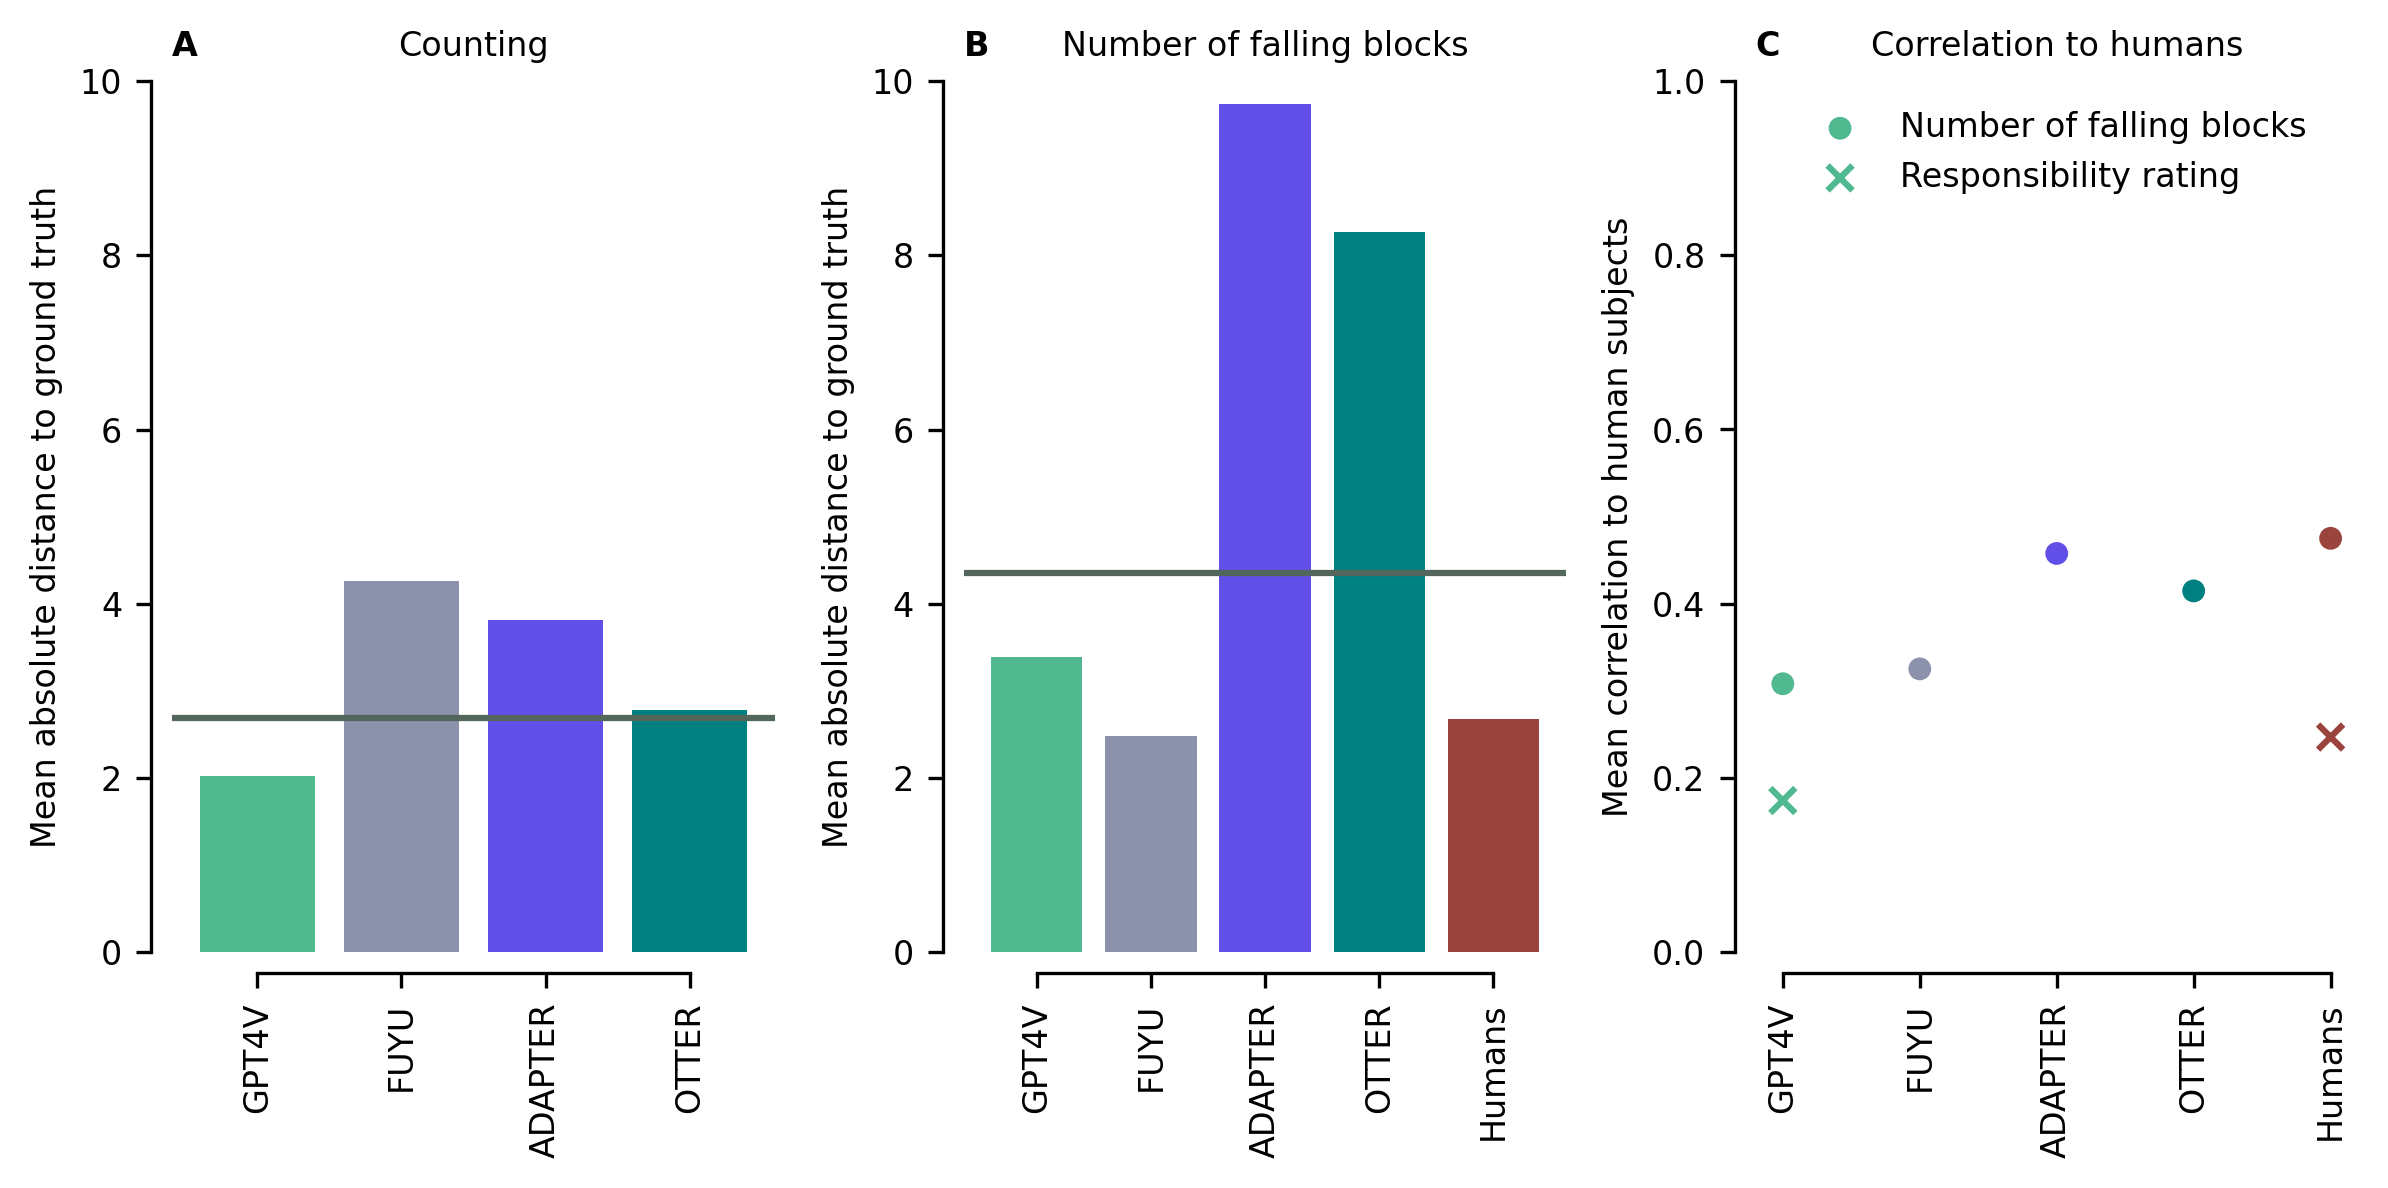

In [42]:
# Prepare plot
num_subjects = len(subjects)
fig, axs = plt.subplots(1, 3, figsize=(8,4), sharey=False, tight_layout=True)  

# Plot A
axs[0].bar(np.arange(num_subjects-1), mean_absolute_dists[0, 0, :], color=model_colors)
axs[0].set_title("Counting")
axs[0].set_title("A", fontweight='bold', loc='left', fontsize='medium')
axs[0].set_ylabel("Mean absolute distance to ground truth")
axs[0].set_ylim(0, 10)
axs[0].axhline(y=random_dists[0])
axs[0].set_xticks(np.arange(num_subjects-1))

# Plot B
axs[1].bar(np.arange(num_subjects), np.hstack((mean_absolute_dists[1, 0, :], np.nanmean(mean_absolute_dists_humans_exp2))), color=model_colors)
axs[1].set_title("Number of falling blocks")
axs[1].set_title("B", fontweight='bold', loc='left', fontsize='medium')
axs[1].set_ylabel("Mean absolute distance to ground truth")
axs[1].set_ylim(0, 10)
axs[1].axhline(y=random_dists[1])
axs[1].set_xticks(np.arange(num_subjects))

# Plot C
axs[2].scatter(np.arange(num_subjects), np.concatenate((np.nanmean(corrs_human_inds[0, :], axis=1), [np.nanmean(human_corrs[0, :])])), 
               label="Number of falling blocks", s=20, marker="o", color=model_colors)
axs[2].scatter(np.arange(num_subjects), np.concatenate((np.nanmean(corrs_human_inds[1, :], axis=1), [np.nanmean(human_corrs[1, :])])), 
               label="Responsibility rating", marker="x", color=model_colors)
axs[2].set_title("Correlation to humans")
axs[2].set_title("C", fontweight='bold', loc='left', fontsize='medium')
axs[2].set_ylabel("Mean correlation to human subjects")
axs[2].set_ylim(0, 1)
axs[2].set_xticks(np.arange(num_subjects))
axs[2].legend(loc="upper center", frameon=False)

# Despine and set x tick labels afterwards
sns.despine(offset=5, trim=True)
axs[0].set_xticklabels(subjects[1:], rotation=90)
axs[1].set_xticklabels(np.hstack((subjects[1:], "Humans")), rotation=90)
axs[2].set_xticklabels(np.hstack((subjects[1:], "Humans")), rotation=90)
plt.savefig("jenga_main.pdf", dpi=300)

## Example plots

In [19]:
# Print images in order from easy to hard for humans 
human_inds_easyhard = np.argsort(abs(data_jenga[data_jenga["Experiment"] == 2]["HumanAvg"].values - data_jenga[data_jenga["Experiment"] == 2]["GT"].values))
human_imgs_easyhard = data_jenga[data_jenga["Experiment"] == 2].iloc[human_inds_easyhard]["Image"]
print(human_imgs_easyhard.values)

[20 38 26 28  2 31 30  8 14 29 22  4 11  1 34 33  9 16 32 41 17 12 27  3
  7 19 25 13 10 24 39 18 15 23 35  6 21 40 37 42 36  5]


In [20]:
# Print images in order from easy to hard for GPT4V
gpt4v_inds_easyhard = np.argsort(abs(data_jenga[data_jenga["Experiment"] == 2]["GPT4V"].values - data_jenga[data_jenga["Experiment"] == 2]["GT"].values))
gpt4v_imgs_easyhard = data_jenga[data_jenga["Experiment"] == 2].iloc[gpt4v_inds_easyhard]["Image"]
print(gpt4v_imgs_easyhard.values)

[30 41 38 22 32 31 15 14 18 24 10 19 26 25 28 29 33 34 27  1 21 16  9  8
  7  4 42 39  2 12 35  3 20 17 11 13 23 37  6 40 36  5]


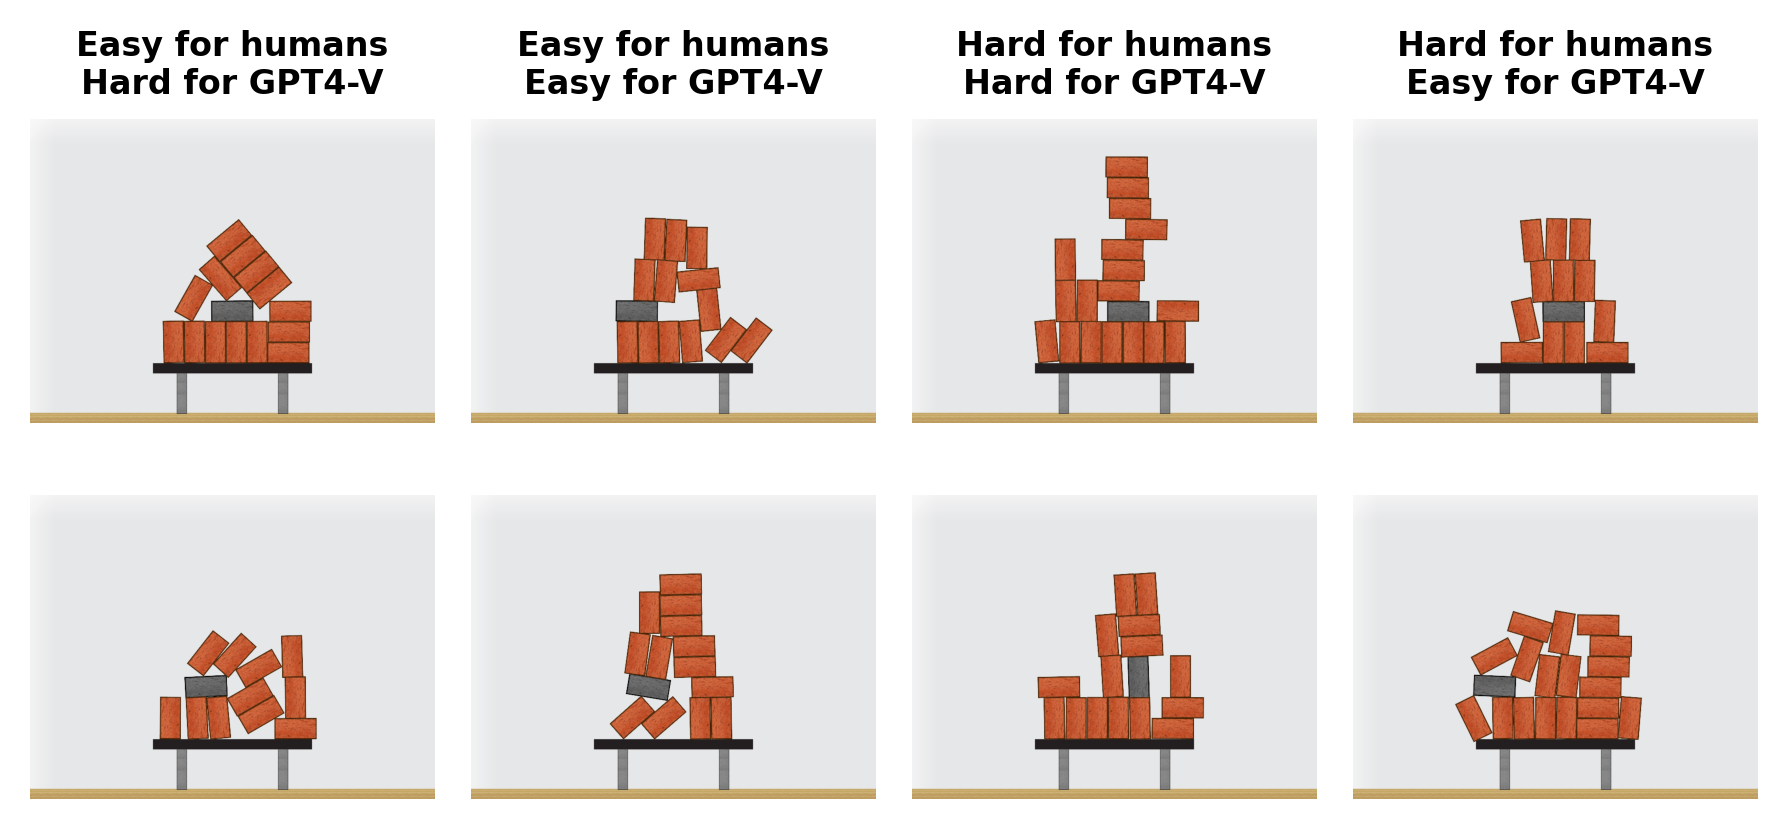

In [21]:
# Prepare plot
fig, axs = plt.subplots(2, 4, sharey=False, tight_layout=True, figsize=(6,4))  

# First column: easy for humans, hard for GPT4V (20, 11)
axs[0, 0].imshow(plt.imread("images/jenga/initial_trial_20_diff_4_index_2.png"))
axs[0, 0].axis("off")
axs[1, 0].imshow(plt.imread("images/jenga/initial_trial_11_diff_2_index_5.png"))
axs[1, 0].axis("off")

# Second column: easy for humans, easy for GPT4V (38, 31)
axs[0, 1].imshow(plt.imread("images/jenga/initial_trial_38_diff_7_index_2.png"))
axs[0, 1].axis("off")
axs[1, 1].imshow(plt.imread("images/jenga/initial_trial_31_diff_6_index_1.png"))
axs[1, 1].axis("off")

# Third column: hard for humans, hard for GPT4V (36, 40)
axs[0, 2].imshow(plt.imread("images/jenga/initial_trial_36_diff_6_index_6.png"))
axs[0, 2].axis("off")
axs[1, 2].imshow(plt.imread("images/jenga/initial_trial_40_diff_7_index_4.png"))
axs[1, 2].axis("off")

# fourth column: hard for humans, easy for GPT4V (15, 18)
axs[0, 3].imshow(plt.imread("images/jenga/initial_trial_15_diff_3_index_3.png"))
axs[0, 3].axis("off")
axs[1, 3].imshow(plt.imread("images/jenga/initial_trial_18_diff_3_index_6.png"))
axs[1, 3].axis("off")

# Set column titles
axs[0, 0].set_title("Easy for humans\nHard for GPT4-V", fontweight="bold")
axs[0, 1].set_title("Easy for humans\nEasy for GPT4-V", fontweight="bold")
axs[0, 2].set_title("Hard for humans\nHard for GPT4-V", fontweight="bold")
axs[0, 3].set_title("Hard for humans\nEasy for GPT4-V", fontweight="bold")
plt.savefig("jenga_examples.pdf", dpi=300)